In [152]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [153]:
!pip install matplotlib pandas numpy seaborn wordcloud googletrans==4.0.0-rc1
!pip install plotly --upgrade
!pip install nltk
!pip install vncorenlp

In [154]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar -O vncorenlp/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab -O vncorenlp/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr -O vncorenlp/models/wordsegmenter/wordsegmenter.rdr

--2023-12-05 14:26:19--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘vncorenlp/VnCoreNLP-1.1.1.jar’

vncorenlp/VnCoreNLP 100%[===================>]  26.14M   156MB/s    in 0.2s    

2023-12-05 14:26:20 (156 MB/s) - ‘vncorenlp/VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2023-12-05 14:26:20--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request s

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
import plotly.express as px
from wordcloud import WordCloud
from pathlib import Path
import os
from wordcloud import WordCloud, STOPWORDS
import string
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import json
from datetime import datetime
from vncorenlp import VnCoreNLP
import requests

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [156]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Data analysis with python/T1LoL1.xlsx")
df

,post_id,text,post_text,shared_text,original_text,time,timestamp,image,image_lowquality,images,...,reaction_count,with,page_id,sharers,image_id,image_ids,video_ids,videos,was_live,fetched_time
0,883924476474709,'Oner'와 'Faker'는 Mercedes-Benz Korea AMG Speed...,'Oner'와 'Faker'는 Mercedes-Benz Korea AMG Speed...,NaN,NaN,2023-11-28 09:00:06,1701162006,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,9962,NaN,1512166985684128,NaN,NaN,[],[],[],False,2023-11-28 11:15:55.300
1,883325626534594,T1 League of Legends 'Roach' 김강희 코치가 2024년에도 T...,T1 League of Legends 'Roach' 김강희 코치가 2024년에도 T...,NaN,NaN,2023-11-27 04:00:05,1701057605,https://m.facebook.com/photo/view_full_size/?f...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://m.facebook.com/photo/view_full_size/...,...,23089,NaN,1512166985684128,NaN,8.833255e+14,['883325529867937'],NaN,NaN,False,2023-11-28 11:16:26.347
2,882934579907032,[2023 #LCK Academy Full League Finals]\n\nT1A ...,[2023 #LCK Academy Full League Finals]\n\nT1A ...,NaN,[2023 #LCK Academy Full League Finals]\n\nT1A ...,2023-11-26 07:33:19,1700983999,https://m.facebook.com/photo/view_full_size/?f...,https://scontent-iad3-1.xx.fbcdn.net/v/t39.308...,['https://m.facebook.com/photo/view_full_size/...,...,3289,NaN,1512166985684128,NaN,8.829327e+14,['882932703240553'],NaN,NaN,False,2023-11-28 11:16:37.308
3,882820379918452,[2023 #LCK Academy Full League Finals]\n\n오늘은 ...,[2023 #LCK Academy Full League Finals]\n\n오늘은 ...,NaN,NaN,2023-11-26 04:00:04,1700971204,NaN,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,[],...,1501,NaN,1512166985684128,NaN,8.828203e+14,['882820333251790'],NaN,NaN,False,2023-11-28 11:16:50.091
4,882554799945010,[2023 #LCK Academy Full League PO R1]\n\nT1A R...,[2023 #LCK Academy Full League PO R1]\n\nT1A R...,NaN,[2023 #LCK Academy Full League PO R1]\n\nT1A R...,2023-11-25 12:32:33,1700915553,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,4800,NaN,1512166985684128,NaN,8.825547e+14,['882554713278352'],NaN,NaN,False,2023-11-28 11:16:54.736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3514042632163210,[2023 #LCK Spring R2 M16 vs. HLE]\n\n설욕전 성ㅋ공ㅋ\...,[2023 #LCK Spring R2 M16 vs. HLE]\n\n설욕전 성ㅋ공ㅋ\...,NaN,NaN,2023-03-11 12:03:11,1678536191,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,0,NaN,1512166985684128,NaN,3.514043e+15,['3514042545496552'],NaN,NaN,False,NaT
496,3514027718831368,"[2023 #LCK Spring R2 M16 vs. HLE]\n\n3,000 어시스...","[2023 #LCK Spring R2 M16 vs. HLE]\n\n3,000 어시스...",NaN,NaN,2023-03-11 11:34:02,1678534442,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,0,NaN,1512166985684128,NaN,3.514027e+15,['3514027232164750'],NaN,NaN,False,NaT
497,3514010542166419,"OUR SUPPORTER, KERIA | 2020.02.07~\n\nLCK 통산 3...","OUR SUPPORTER, KERIA | 2020.02.07~\n\nLCK 통산 3...",NaN,"OUR SUPPORTER, KERIA | 2020.02.07~\n\nLCK 통산 3...",2023-03-11 10:56:04,1678532164,https://scontent-iad3-1.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-1.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-1.xx.fbcdn.net/v/t39.3...,...,0,NaN,1512166985684128,NaN,3.514010e+15,['3514010488833091'],NaN,NaN,False,NaT
498,3513283655572441,[2023 #LCK Spring R2 M16 vs. HLE]\n\n복수의 칼날을 갈...,[2023 #LCK Spring R2 M16 vs. HLE]\n\n복수의 칼날을 갈...,NaN,NaN,2023-03-11 07:30:01,1678519801,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,0,NaN,1512166985684128,NaN,3.513284e+15,['3513283528905787'],NaN,NaN,False,NaT


### **Data** **cleaning**

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   post_id                        500 non-null    int64         
 1   text                           492 non-null    object        
 2   post_text                      492 non-null    object        
 3   shared_text                    0 non-null      float64       
 4   original_text                  35 non-null     object        
 5   time                           500 non-null    datetime64[ns]
 6   timestamp                      500 non-null    int64         
 7   image                          473 non-null    object        
 8   image_lowquality               500 non-null    object        
 9   images                         492 non-null    object        
 10  images_description             492 non-null    object        
 11  images_lowquality  

In [158]:
df['reaction_count'].replace( 0, None, inplace = True)
df.dropna(subset=['reaction_count', 'text'], inplace = True)

In [159]:
columns_to_drop = ['shared_text','original_text', 'video_duration_seconds', 'video_height', 'video_quality', 'video_size_MB', 'video_thumbnail', 'video_watches',
                  'video_width', 'factcheck', 'sharers', 'is_live', 'was_live', 'videos', 'with', 'video_ids']
df = df.drop(columns = columns_to_drop)


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124 entries, 0 to 125
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   post_id                        124 non-null    int64         
 1   text                           124 non-null    object        
 2   post_text                      124 non-null    object        
 3   time                           124 non-null    datetime64[ns]
 4   timestamp                      124 non-null    int64         
 5   image                          115 non-null    object        
 6   image_lowquality               124 non-null    object        
 7   images                         124 non-null    object        
 8   images_description             124 non-null    object        
 9   images_lowquality              124 non-null    object        
 10  images_lowquality_description  124 non-null    object        
 11  video              

In [161]:
df['reaction_count'] = pd.to_numeric(df['reaction_count'], errors='coerce').astype('float64')

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124 entries, 0 to 125
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   post_id                        124 non-null    int64         
 1   text                           124 non-null    object        
 2   post_text                      124 non-null    object        
 3   time                           124 non-null    datetime64[ns]
 4   timestamp                      124 non-null    int64         
 5   image                          115 non-null    object        
 6   image_lowquality               124 non-null    object        
 7   images                         124 non-null    object        
 8   images_description             124 non-null    object        
 9   images_lowquality              124 non-null    object        
 10  images_lowquality_description  124 non-null    object        
 11  video              

### **Data Prepocessing**

In [163]:
from googletrans import Translator

In [164]:
def translate_text(text, target_language='en'):
    translator = Translator()
    translation = translator.translate(text, dest=target_language)
    return translation.text

In [165]:
df.head()

,post_id,text,post_text,time,timestamp,image,image_lowquality,images,images_description,images_lowquality,...,available,comments_full,reactors,w3_fb_url,reactions,reaction_count,page_id,image_id,image_ids,fetched_time
0,883924476474709,'Oner'와 'Faker'는 Mercedes-Benz Korea AMG Speed...,'Oner'와 'Faker'는 Mercedes-Benz Korea AMG Speed...,2023-11-28 09:00:06,1701162006,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,"['Có thể là hình ảnh về 1 người và văn bản', '...",['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,True,"[{'comment_id': '6668868236543112', 'comment_u...","[{'name': 'Mặt Cười', 'link': 'https://faceboo...",https://www.facebook.com/T1LoL/posts/883924476...,"{'thích': 5540, 'yêu thích': 4274, 'haha': 47,...",9962.0,1512166985684128,NaN,[],2023-11-28 11:15:55.300
1,883325626534594,T1 League of Legends 'Roach' 김강희 코치가 2024년에도 T...,T1 League of Legends 'Roach' 김강희 코치가 2024년에도 T...,2023-11-27 04:00:05,1701057605,https://m.facebook.com/photo/view_full_size/?f...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://m.facebook.com/photo/view_full_size/...,['Có thể là hình ảnh về 1 người và văn bản'],['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,True,"[{'comment_id': '318447274292388', 'comment_ur...","[{'name': 'Socola Sữa', 'link': 'https://faceb...",https://www.facebook.com/T1LoL/posts/883325626...,"{'thích': 13414, 'yêu thích': 9147, 'haha': 19...",23089.0,1512166985684128,8.833255e+14,['883325529867937'],2023-11-28 11:16:26.347
2,882934579907032,[2023 #LCK Academy Full League Finals]\n\nT1A ...,[2023 #LCK Academy Full League Finals]\n\nT1A ...,2023-11-26 07:33:19,1700983999,https://m.facebook.com/photo/view_full_size/?f...,https://scontent-iad3-1.xx.fbcdn.net/v/t39.308...,['https://m.facebook.com/photo/view_full_size/...,['Có thể là hình ảnh về văn bản'],['https://scontent-iad3-1.xx.fbcdn.net/v/t39.3...,...,True,"[{'comment_id': '1031968541363093', 'comment_u...","[{'name': 'Kyaw Soe Thet', 'link': 'https://fa...",https://www.facebook.com/T1LoL/posts/882934579...,"{'thích': 2357, 'yêu thích': 331, 'haha': 20, ...",3289.0,1512166985684128,8.829327e+14,['882932703240553'],2023-11-28 11:16:37.308
3,882820379918452,[2023 #LCK Academy Full League Finals]\n\n오늘은 ...,[2023 #LCK Academy Full League Finals]\n\n오늘은 ...,2023-11-26 04:00:04,1700971204,NaN,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,[],[],['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,True,"[{'comment_id': '1724297751371415', 'comment_u...","[{'name': 'Nguyễn Trân', 'link': 'https://face...",https://www.facebook.com/T1LoL/posts/882820379...,"{'thích': 1146, 'yêu thích': 342, 'haha': 4, '...",1501.0,1512166985684128,8.828203e+14,['882820333251790'],2023-11-28 11:16:50.091
4,882554799945010,[2023 #LCK Academy Full League PO R1]\n\nT1A R...,[2023 #LCK Academy Full League PO R1]\n\nT1A R...,2023-11-25 12:32:33,1700915553,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,['Có thể là đồ họa về văn bản'],['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,True,"[{'comment_id': '1025802525296608', 'comment_u...","[{'name': 'Kyaw Soe Thet', 'link': 'https://fa...",https://www.facebook.com/T1LoL/posts/882554799...,"{'thích': 3436, 'yêu thích': 1309, 'haha': 13,...",4800.0,1512166985684128,8.825547e+14,['882554713278352'],2023-11-28 11:16:54.736


In [166]:
df['post_text'] = df['post_text'].apply(translate_text)

In [167]:
df[['text', 'post_text']]

,text,post_text
0,'Oner'와 'Faker'는 Mercedes-Benz Korea AMG Speed...,'Oner' and 'FAKER' shine in Mercedes-Benz Kore...
1,T1 League of Legends 'Roach' 김강희 코치가 2024년에도 T...,T1 League of Legends 'Roach' coach Kim Kang -h...
2,[2023 #LCK Academy Full League Finals]\n\nT1A ...,[2023 #LCK Academy Full League Finals]\n\nFini...
3,[2023 #LCK Academy Full League Finals]\n\n오늘은 ...,[2023 #LCK Academy Full League Finals]\n\nToda...
4,[2023 #LCK Academy Full League PO R1]\n\nT1A R...,[2023 #LCK Academy Full League Po R1]\n\nT1A R...
...,...,...
121,T1과 T1 팬들이 함께 시작하는 Worlds 2023에서의 여정.🗺\n\nThe ...,"The journey in Worlds 2023, where T1 and T1 fa..."
122,[T1 x T Factory] The Hero`s Journey Pop-Up Sto...,[T1 x T Factory] The Hero`s Journey Pop-up sto...
123,Why choose only one thing to do? See it all to...,Why choose only one thing to do? See it all to...
124,"Catch every detail and conquer your fears, eve...","Catch every detail and conquer your fears, eve..."


In [168]:
df = df.sort_values(by = 'timestamp', ascending = True)
df

,post_id,text,post_text,time,timestamp,image,image_lowquality,images,images_description,images_lowquality,...,available,comments_full,reactors,w3_fb_url,reactions,reaction_count,page_id,image_id,image_ids,fetched_time
125,857090949158062,Expand epic moments in your favorite games wit...,Expand epic moments in your favorite games wit...,2023-10-07 09:08:49,1696669729,NaN,https://scontent-iad3-1.xx.fbcdn.net/v/t15.525...,[],[],['https://scontent-iad3-1.xx.fbcdn.net/v/t15.5...,...,True,"[{'comment_id': '284073597849075', 'comment_ur...","[{'name': 'Cánh Cụt', 'link': 'https://faceboo...",https://www.facebook.com/T1LoL/posts/857090949...,"{'thích': 713, 'yêu thích': 562, 'haha': 382, ...",1681.0,1512166985684128,NaN,[],2023-11-28 11:45:57.442
124,857118535821970,"Catch every detail and conquer your fears, eve...","Catch every detail and conquer your fears, eve...",2023-10-07 10:24:07,1696674247,NaN,https://scontent-iad3-1.xx.fbcdn.net/v/t15.525...,[],[],['https://scontent-iad3-1.xx.fbcdn.net/v/t15.5...,...,True,[],"[{'name': 'Mặt Cười', 'link': 'https://faceboo...",https://www.facebook.com/T1LoL/posts/857118535...,"{'thích': 310, 'yêu thích': 285, 'haha': 16, '...",617.0,1512166985684128,NaN,[],2023-11-28 11:45:54.234
123,857147109152446,Why choose only one thing to do? See it all to...,Why choose only one thing to do? See it all to...,2023-10-07 11:39:01,1696678741,NaN,https://scontent-iad3-2.xx.fbcdn.net/v/t15.525...,[],[],['https://scontent-iad3-2.xx.fbcdn.net/v/t15.5...,...,True,"[{'comment_id': '3730520083847722', 'comment_u...","[{'name': 'Cánh Cụt', 'link': 'https://faceboo...",https://www.facebook.com/T1LoL/posts/857147109...,"{'thích': 401, 'yêu thích': 339, 'haha': 18, '...",768.0,1512166985684128,NaN,[],2023-11-28 11:45:51.391
122,857214232479067,[T1 x T Factory] The Hero`s Journey Pop-Up Sto...,[T1 x T Factory] The Hero`s Journey Pop-up sto...,2023-10-08 03:00:02,1696734002,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,['Có thể là hình minh họa về văn bản'],['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,True,"[{'comment_id': '310421064939824', 'comment_ur...","[{'name': 'Calan Milan', 'link': 'https://face...",https://www.facebook.com/T1LoL/posts/857214232...,"{'thích': 785, 'yêu thích': 594, 'haha': 2, 'w...",1400.0,1512166985684128,8.572168e+14,['857216762478814'],2023-11-28 11:45:47.470
121,857212265812597,T1과 T1 팬들이 함께 시작하는 Worlds 2023에서의 여정.🗺\n\nThe ...,"The journey in Worlds 2023, where T1 and T1 fa...",2023-10-08 09:00:01,1696755601,https://scontent-iad3-1.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-1.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-1.xx.fbcdn.net/v/t39.3...,"[""Có thể là hình ảnh về bản đồ và văn bản cho ...",['https://scontent-iad3-1.xx.fbcdn.net/v/t39.3...,...,True,"[{'comment_id': '219785591118342', 'comment_ur...","[{'name': 'Mặt Cười', 'link': 'https://faceboo...",https://www.facebook.com/T1LoL/posts/857212265...,"{'thích': 624, 'yêu thích': 381, 'haha': 2, 't...",1013.0,1512166985684128,NaN,[],2023-11-28 11:45:42.793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,882554799945010,[2023 #LCK Academy Full League PO R1]\n\nT1A R...,[2023 #LCK Academy Full League Po R1]\n\nT1A R...,2023-11-25 12:32:33,1700915553,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,['Có thể là đồ họa về văn bản'],['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,True,"[{'comment_id': '1025802525296608', 'comment_u...","[{'name': 'Kyaw Soe Thet', 'link': 'https://fa...",https://www.facebook.com/T1LoL/posts/882554799...,"{'thích': 3436, 'yêu thích': 1309, 'haha': 13,...",4800.0,1512166985684128,8.825547e+14,['882554713278352'],2023-11-28 11:16:54.736
3,882820379918452,[2023 #LCK Academy Full League Finals]\n\n오늘은 ...,[2023 #LCK Academy Full League Finals]\n\

In [169]:
df['week_of_year'] = pd.to_datetime(df['time']).dt.isocalendar().week
df

,post_id,text,post_text,time,timestamp,image,image_lowquality,images,images_description,images_lowquality,...,comments_full,reactors,w3_fb_url,reactions,reaction_count,page_id,image_id,image_ids,fetched_time,week_of_year
125,857090949158062,Expand epic moments in your favorite games wit...,Expand epic moments in your favorite games wit...,2023-10-07 09:08:49,1696669729,NaN,https://scontent-iad3-1.xx.fbcdn.net/v/t15.525...,[],[],['https://scontent-iad3-1.xx.fbcdn.net/v/t15.5...,...,"[{'comment_id': '284073597849075', 'comment_ur...","[{'name': 'Cánh Cụt', 'link': 'https://faceboo...",https://www.facebook.com/T1LoL/posts/857090949...,"{'thích': 713, 'yêu thích': 562, 'haha': 382, ...",1681.0,1512166985684128,NaN,[],2023-11-28 11:45:57.442,40
124,857118535821970,"Catch every detail and conquer your fears, eve...","Catch every detail and conquer your fears, eve...",2023-10-07 10:24:07,1696674247,NaN,https://scontent-iad3-1.xx.fbcdn.net/v/t15.525...,[],[],['https://scontent-iad3-1.xx.fbcdn.net/v/t15.5...,...,[],"[{'name': 'Mặt Cười', 'link': 'https://faceboo...",https://www.facebook.com/T1LoL/posts/857118535...,"{'thích': 310, 'yêu thích': 285, 'haha': 16, '...",617.0,1512166985684128,NaN,[],2023-11-28 11:45:54.234,40
123,857147109152446,Why choose only one thing to do? See it all to...,Why choose only one thing to do? See it all to...,2023-10-07 11:39:01,1696678741,NaN,https://scontent-iad3-2.xx.fbcdn.net/v/t15.525...,[],[],['https://scontent-iad3-2.xx.fbcdn.net/v/t15.5...,...,"[{'comment_id': '3730520083847722', 'comment_u...","[{'name': 'Cánh Cụt', 'link': 'https://faceboo...",https://www.facebook.com/T1LoL/posts/857147109...,"{'thích': 401, 'yêu thích': 339, 'haha': 18, '...",768.0,1512166985684128,NaN,[],2023-11-28 11:45:51.391,40
122,857214232479067,[T1 x T Factory] The Hero`s Journey Pop-Up Sto...,[T1 x T Factory] The Hero`s Journey Pop-up sto...,2023-10-08 03:00:02,1696734002,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,['Có thể là hình minh họa về văn bản'],['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,"[{'comment_id': '310421064939824', 'comment_ur...","[{'name': 'Calan Milan', 'link': 'https://face...",https://www.facebook.com/T1LoL/posts/857214232...,"{'thích': 785, 'yêu thích': 594, 'haha': 2, 'w...",1400.0,1512166985684128,8.572168e+14,['857216762478814'],2023-11-28 11:45:47.470,40
121,857212265812597,T1과 T1 팬들이 함께 시작하는 Worlds 2023에서의 여정.🗺\n\nThe ...,"The journey in Worlds 2023, where T1 and T1 fa...",2023-10-08 09:00:01,1696755601,https://scontent-iad3-1.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-1.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-1.xx.fbcdn.net/v/t39.3...,"[""Có thể là hình ảnh về bản đồ và văn bản cho ...",['https://scontent-iad3-1.xx.fbcdn.net/v/t39.3...,...,"[{'comment_id': '219785591118342', 'comment_ur...","[{'name': 'Mặt Cười', 'link': 'https://faceboo...",https://www.facebook.com/T1LoL/posts/857212265...,"{'thích': 624, 'yêu thích': 381, 'haha': 2, 't...",1013.0,1512166985684128,NaN,[],2023-11-28 11:45:42.793,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,882554799945010,[2023 #LCK Academy Full League PO R1]\n\nT1A R...,[2023 #LCK Academy Full League Po R1]\n\nT1A R...,2023-11-25 12:32:33,1700915553,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,['Có thể là đồ họa về văn bản'],['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,"[{'comment_id': '1025802525296608', 'comment_u...","[{'name': 'Kyaw Soe Thet', 'link': 'https://fa...",https://www.facebook.com/T1LoL/posts/882554799...,"{'thích': 3436, 'yêu thích': 1309, 'haha': 13,...",4800.0,1512166985684128,8.825547e+14,['882554713278352'],2023-11-28 11:16:54.736,47
3,882820379918452,[2023 #LCK Academy Full League Finals]\n\n오늘은 ...,[2023 #LCK Academy Full League Finals]\n\nToda...,

### **Reactions Analysis**

Productivity from 2 months recently

In [170]:
Dates = df['time'].tolist()
Rec_count = df['reaction_count'].tolist()

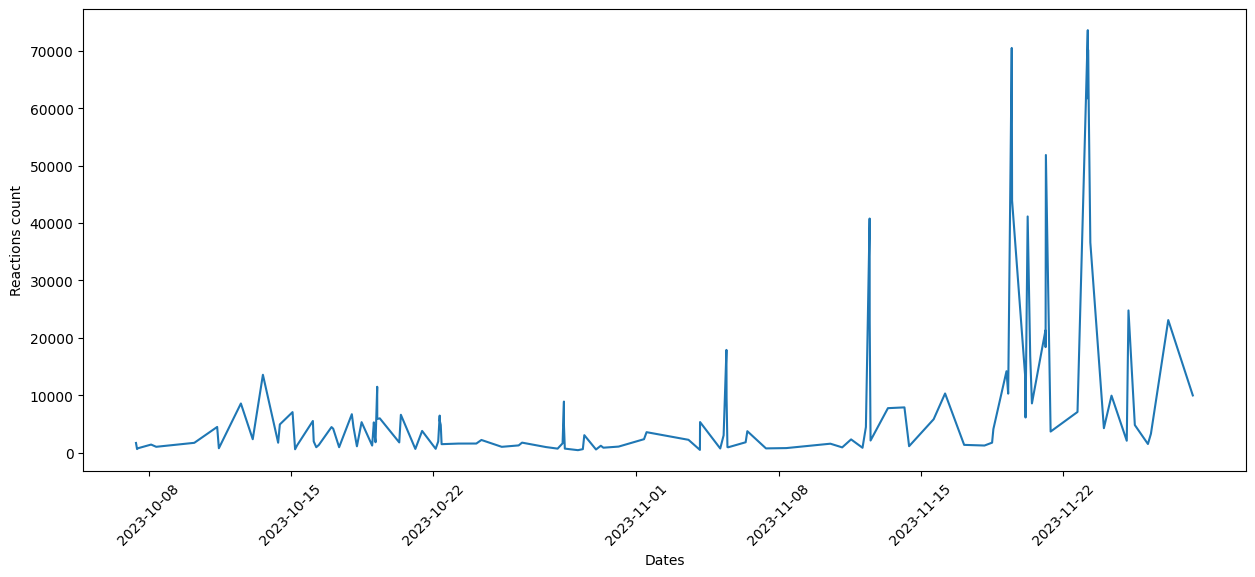

In [171]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(Dates, Rec_count)

# Use AutoDateLocator to automatically choose the date ticks
locator = AutoDateLocator()
ax.xaxis.set_major_locator(locator)

# Use AutoDateFormatter to format the date ticks
formatter = AutoDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)

# Rotate the x-axis labels for better visibility (optional)
plt.xticks(rotation=45)
plt.xlabel('Dates')
plt.ylabel('Reactions count')

# Show the plot
plt.show()


Productivity every day

In [172]:
df1 = df
df1['reactions'] = df['reactions'].apply(lambda x : dict(eval(x)))
df_full_reactions = df1['reactions'].apply(pd.Series)

df_full_reactions = df

In [173]:
df_full_reactions = pd.concat([df1, df_full_reactions], axis = 1).drop('reactions', axis = 1)
selected_columns = ['post_text','thích','yêu thích','haha','wow','buồn','phẫn nộ','thương thương',
                     'shares','comments','reaction_count']
selected_data = df_full_reactions[selected_columns]

In [174]:
selected_data

,post_text,thích,yêu thích,haha,wow,buồn,phẫn nộ,thương thương,shares,comments,reaction_count
125,Expand epic moments in your favorite games wit...,713.0,562.0,382.0,11.0,1.0,NaN,12.0,68,14,1681.0
124,"Catch every detail and conquer your fears, eve...",310.0,285.0,16.0,2.0,1.0,NaN,3.0,8,0,617.0
123,Why choose only one thing to do? See it all to...,401.0,339.0,18.0,3.0,1.0,NaN,6.0,13,3,768.0
122,[T1 x T Factory] The Hero`s Journey Pop-up sto...,785.0,594.0,2.0,4.0,NaN,NaN,15.0,16,7,1400.0
121,"The journey in Worlds 2023, where T1 and T1 fa...",624.0,381.0,2.0,NaN,NaN,NaN,6.0,9,6,1013.0
...,...,...,...,...,...,...,...,...,...,...,...
4,[2023 #LCK Academy Full League Po R1]\n\nT1A R...,3436.0,1309.0,13.0,2.0,2.0,NaN,38.0,13,73,4800.0
3,[2023 #LCK Academy Full League Finals]\n\nToda...,1146.0,342.0,4.0,1.0,NaN,NaN,8.0,8,8,1501.0
2,[2023 #LCK Academy Full League Finals]\n\nFini...,2357.0,331.0,20.0,7.0,533.0,1.0,40.0,12,131,3289.0
1,T1 League of Legends 'Roach' coach Kim Kang -h...,13414.0,9147.0,191.0,117.0,6.0,NaN,214.0,626,683,23089.0


In [175]:
selected_data.fillna(0)

,post_text,thích,yêu thích,haha,wow,buồn,phẫn nộ,thương thương,shares,comments,reaction_count
125,Expand epic moments in your favorite games wit...,713.0,562.0,382.0,11.0,1.0,0.0,12.0,68,14,1681.0
124,"Catch every detail and conquer your fears, eve...",310.0,285.0,16.0,2.0,1.0,0.0,3.0,8,0,617.0
123,Why choose only one thing to do? See it all to...,401.0,339.0,18.0,3.0,1.0,0.0,6.0,13,3,768.0
122,[T1 x T Factory] The Hero`s Journey Pop-up sto...,785.0,594.0,2.0,4.0,0.0,0.0,15.0,16,7,1400.0
121,"The journey in Worlds 2023, where T1 and T1 fa...",624.0,381.0,2.0,0.0,0.0,0.0,6.0,9,6,1013.0
...,...,...,...,...,...,...,...,...,...,...,...
4,[2023 #LCK Academy Full League Po R1]\n\nT1A R...,3436.0,1309.0,13.0,2.0,2.0,0.0,38.0,13,73,4800.0
3,[2023 #LCK Academy Full League Finals]\n\nToda...,1146.0,342.0,4.0,1.0,0.0,0.0,8.0,8,8,1501.0
2,[2023 #LCK Academy Full League Finals]\n\nFini...,2357.0,331.0,20.0,7.0,533.0,1.0,40.0,12,131,3289.0
1,T1 League of Legends 'Roach' coach Kim Kang -h...,13414.0,9147.0,191.0,117.0,6.0,0.0,214.0,626,683,23089.0


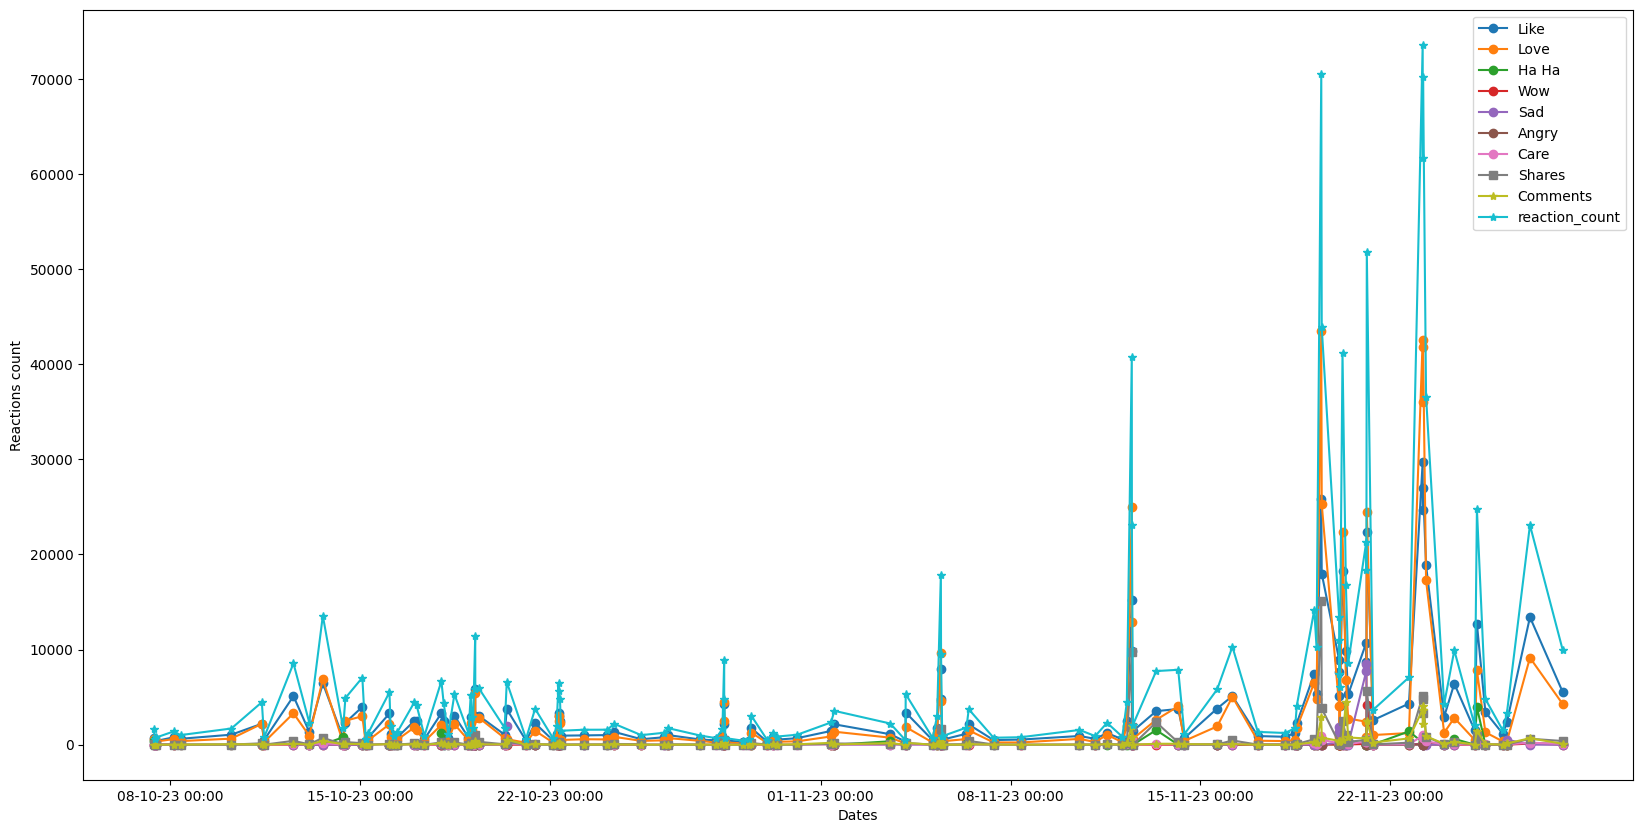

In [176]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df_full_reactions['time'], df_full_reactions['thích'], label = "Like", marker="o")
ax.plot(df_full_reactions['time'], df_full_reactions['yêu thích'], label = "Love", marker="o")
ax.plot(df_full_reactions['time'], df_full_reactions['haha'], label = "Ha Ha", marker="o")
ax.plot(df_full_reactions['time'], df_full_reactions['wow'], label = "Wow", marker="o")
ax.plot(df_full_reactions['time'], df_full_reactions['buồn'], label = "Sad", marker="o")
ax.plot(df_full_reactions['time'], df_full_reactions['phẫn nộ'], label = "Angry", marker="o")
ax.plot(df_full_reactions['time'], df_full_reactions['thương thương'], label = "Care", marker="o")
ax.plot(df_full_reactions['time'], df_full_reactions['shares'], label = "Shares", marker="s")
ax.plot(df_full_reactions['time'], df_full_reactions['comments'], label = "Comments", marker="*")
ax.plot(df_full_reactions['time'], df_full_reactions['reaction_count'], label = "reaction_count", marker="*")

plt.xlabel('Dates')
plt.ylabel('Reactions count')
plt.legend()
from matplotlib.dates import DateFormatter
ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%y %H:%M'))


In [177]:
print(df_full_reactions[['thích', 'yêu thích', 'thương thương', 'phẫn nộ', 'haha', 'wow', 'buồn']].corrwith(df_full_reactions['reaction_count']))

thích            0.988450
yêu thích        0.979715
thương thương    0.991014
phẫn nộ         -0.109326
haha             0.149588
wow              0.306699
buồn             0.044643
dtype: float64


In [178]:
correlation_matrix = df_full_reactions[['thích', 'yêu thích', 'thương thương', 'phẫn nộ', 'haha', 'wow', 'buồn']].corrwith(df_full_reactions['reaction_count'])
correlation_df = pd.DataFrame({'Biểu cảm': correlation_matrix.index, 'Tương quan': correlation_matrix.values})
fig = px.bar(correlation_df, x='Biểu cảm', y='Tương quan', title='Tương quan giữa các biểu cảm và số lượt phản ứng')
fig.show()

In [179]:
print(df_full_reactions[['thích', 'yêu thích', 'thương thương', 'phẫn nộ', 'haha', 'wow', 'buồn']].corrwith(df_full_reactions['shares']))

thích            0.750875
yêu thích        0.841570
thương thương    0.816535
phẫn nộ         -0.089462
haha             0.080370
wow              0.265241
buồn            -0.057471
dtype: float64


In [180]:
# Tính ma trận tương quan
correlation_matrix_shares = df_full_reactions[['thích', 'yêu thích', 'thương thương', 'phẫn nộ', 'haha', 'wow', 'buồn']].corrwith(df_full_reactions['shares'])

# Tạo DataFrame từ ma trận tương quan
correlation_shares_df = pd.DataFrame({'Biểu cảm': correlation_matrix_shares.index, 'Tương quan với Shares': correlation_matrix_shares.values})

# Vẽ biểu đồ bằng Plotly
fig_shares = px.bar(correlation_shares_df, x='Biểu cảm', y='Tương quan với Shares', title='Tương quan giữa các biểu cảm và số lượt chia sẻ')

# Hiển thị biểu đồ
fig_shares.show()

In [181]:
top_10_posts = df.nlargest(10, 'reaction_count')[['post_id','post_text', 'reaction_count', 'shares']]
top_10_posts = top_10_posts.reset_index(drop = True)
print(top_10_posts)

           post_id                                          post_text  \
0  881422976724859  T1 League of Legends 'ZEUS' Choi Je -je will b...   
1  879553646911792  [#Worlds2023 Finals vs.WBG]\n\nWorlds 에서 의 4 번...   
2  881430436724113  T1 League of Legends 'Keria' Ryu Min -seok wil...   
3  881396813394142  T1 League of Legends 'gumayusi' 이민형 선수가 2024 년...   
4  880418373491986  Welcome Back, 'Kkoma'.\n\n📺: Youtu.be/LWFBH8JJ...   
5  879564203577403  [#WORLDS2023 FINALS VS.Wbg]\n\nThis year, deco...   
6  879944873539336         ⭐⭐⭐⭐\n\n#T1WIN #T1Fighting #T1atWorlds2023   
7  876031937263963  [#WORLDS2023 Knockout Stage Semifinals vs.JDG]...   
8  881481436719013  T1 League of Legends 'Tom' coach Lim Jae -hyun...   
9  882404416626715   T1CON Coming SOON.👋\n\n#T1WIN #T1Fighting #T1CON   

   reaction_count  shares  
0         73592.0    5137  
1         70491.0   15154  
2         70165.0    4843  
3         61710.0    3365  
4         51843.0    5683  
5         43891.0    3814  


In [182]:
max_reaction_post_index = df_full_reactions['reaction_count'].idxmax()
post_with_max_reactions = df.loc[max_reaction_post_index]
print(post_with_max_reactions)

post_id                                                            881422976724859
text                             T1 League of Legends 'Zeus' 최우제 선수가 2024년에도 T1...
post_text                        T1 League of Legends 'ZEUS' Choi Je -je will b...
time                                                           2023-11-23 05:00:05
timestamp                                                               1700715605
image                            https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...
image_lowquality                 https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...
images                           ['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...
images_description                    ['Có thể là hình ảnh về 1 người và văn bản']
images_lowquality                ['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...
images_lowquality_description         ['Có thể là hình ảnh về 1 người và văn bản']
video                                                                          NaN
vide

<ipython-input-183-9a3d50ce75b9>:3: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.




<Axes: xlabel='shares', ylabel='reaction_count'>

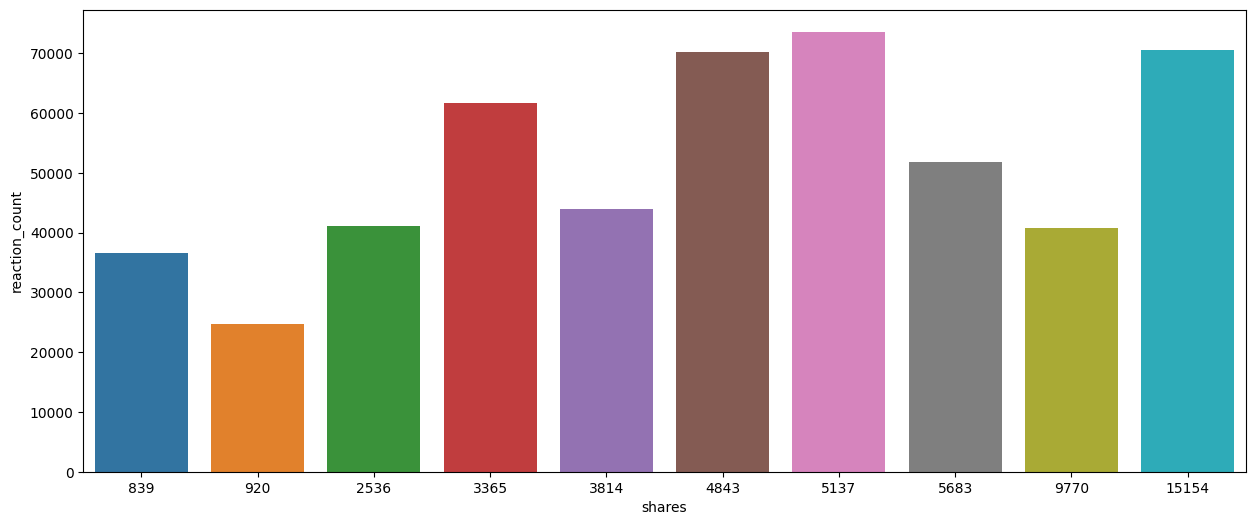

In [183]:
subset_df = df.sample(n = 100)
plt.figure(figsize = (15,6))
sns.barplot(x = 'shares', y = 'reaction_count',data = top_10_posts, ci = "sd", capsize = 0.2)

In [184]:
px.histogram(df, x = "reaction_count", nbins = 2, title = "HISTOGRAM OF REACTIONS")


In [185]:
fig = px.box(df, y = 'reaction_count', title= "BOX PLOT OF REACTION COUNT", hover_data = ['week_of_year'])
fig.update_layout(width = 800, height = 500)
fig.show()

In [186]:
fig = px.scatter(df, x = 'week_of_year',y = 'reaction_count', title= "REACTIONS BASE ON WEEK OF THE YEAR")
fig.update_traces(marker = dict(size = 5,
                               line = dict(width = 2,
                                           color = 'DarkSlateGrey')),
                  selector = dict(mode = 'markers'))
fig.show()

In [187]:
px.bar(df_full_reactions, x = 'week_of_year', y = 'reaction_count', color = 'shares')

In [188]:
df['hour'] = df['time'].dt.hour

posts_per_hour = df['hour'].value_counts().sort_index()
fig = px.line(x=posts_per_hour.index, y=posts_per_hour.values, labels={'x': 'Giờ', 'y': 'Số lượng bài đăng'},
              title='Thói quen đăng bài trong ngày')
fig.show()

In [189]:
df['hour'] = df['time'].dt.hour

fig = px.scatter(df, x='hour', y='reaction_count', color='reaction_count',
                 labels={'hour': 'Giờ', 'reaction_count': 'Số lượng biểu cảm'},
                 title='Tương quan giữa thời gian đăng bài và số lượng biểu cảm',
                 hover_name='hour', hover_data={'hour': False, 'reaction_count': True},
                 color_continuous_scale='Viridis', size_max=15)

fig.show()

In [190]:
df_full_reactions

,post_id,text,post_text,time,timestamp,image,image_lowquality,images,images_description,images_lowquality,...,image_ids,fetched_time,week_of_year,thích,yêu thích,haha,wow,thương thương,buồn,phẫn nộ
125,857090949158062,Expand epic moments in your favorite games wit...,Expand epic moments in your favorite games wit...,2023-10-07 09:08:49,1696669729,NaN,https://scontent-iad3-1.xx.fbcdn.net/v/t15.525...,[],[],['https://scontent-iad3-1.xx.fbcdn.net/v/t15.5...,...,[],2023-11-28 11:45:57.442,40,713.0,562.0,382.0,11.0,12.0,1.0,NaN
124,857118535821970,"Catch every detail and conquer your fears, eve...","Catch every detail and conquer your fears, eve...",2023-10-07 10:24:07,1696674247,NaN,https://scontent-iad3-1.xx.fbcdn.net/v/t15.525...,[],[],['https://scontent-iad3-1.xx.fbcdn.net/v/t15.5...,...,[],2023-11-28 11:45:54.234,40,310.0,285.0,16.0,2.0,3.0,1.0,NaN
123,857147109152446,Why choose only one thing to do? See it all to...,Why choose only one thing to do? See it all to...,2023-10-07 11:39:01,1696678741,NaN,https://scontent-iad3-2.xx.fbcdn.net/v/t15.525...,[],[],['https://scontent-iad3-2.xx.fbcdn.net/v/t15.5...,...,[],2023-11-28 11:45:51.391,40,401.0,339.0,18.0,3.0,6.0,1.0,NaN
122,857214232479067,[T1 x T Factory] The Hero`s Journey Pop-Up Sto...,[T1 x T Factory] The Hero`s Journey Pop-up sto...,2023-10-08 03:00:02,1696734002,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,['Có thể là hình minh họa về văn bản'],['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,['857216762478814'],2023-11-28 11:45:47.470,40,785.0,594.0,2.0,4.0,15.0,NaN,NaN
121,857212265812597,T1과 T1 팬들이 함께 시작하는 Worlds 2023에서의 여정.🗺\n\nThe ...,"The journey in Worlds 2023, where T1 and T1 fa...",2023-10-08 09:00:01,1696755601,https://scontent-iad3-1.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-1.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-1.xx.fbcdn.net/v/t39.3...,"[""Có thể là hình ảnh về bản đồ và văn bản cho ...",['https://scontent-iad3-1.xx.fbcdn.net/v/t39.3...,...,[],2023-11-28 11:45:42.793,40,624.0,381.0,2.0,NaN,6.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,882554799945010,[2023 #LCK Academy Full League PO R1]\n\nT1A R...,[2023 #LCK Academy Full League Po R1]\n\nT1A R...,2023-11-25 12:32:33,1700915553,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,['Có thể là đồ họa về văn bản'],['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,['882554713278352'],2023-11-28 11:16:54.736,47,3436.0,1309.0,13.0,2.0,38.0,2.0,NaN
3,882820379918452,[2023 #LCK Academy Full League Finals]\n\n오늘은 ...,[2023 #LCK Academy Full League Finals]\n\nToda...,2023-11-26 04:00:04,1700971204,NaN,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,[],[],['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,['882820333251790'],2023-11-28 11:16:50.091,47,1146.0,342.0,4.0,1.0,8.0,NaN,NaN
2,882934579907032,[2023 #LCK Academy Full League Finals]\n\nT1A ...,[2023 #LCK Academy Full League Finals]\n\nFini...,2023-11-26 07:33:19,1700983999,https://m.facebook.com/photo/view_full_size/?f...,https://scontent-iad3-1.xx.fbcdn.net/v/t39.308...,['https://m.facebook.com/photo/view_full_size/...,['Có thể là hình ảnh về văn bản'],['https://scontent-iad3-1.xx.fbcdn.net/v/t39.3...,...,['882932703240553'],2023-11-28 11:16:37.308,47,2357.0,331.0,20.0,7.0,40.0,533.0,1.0
1,883325626534594,T1 League of Legends 'Roach' 김강희 코치가 2024년에도 T...,T1 League of Legends 'Roach' coach Kim Kang -h...,2023-11-27 04:00:05,1701057605,https://m.facebook.com/photo/view_full_size/?f...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://m.facebook.com/photo/view_full_size/...,['Có thể là hình ảnh về 1 người và văn bản'],['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,['883325529867937'],2023-11-28 11:16:26.347,48,13414.0,9147.0,191.0,117.0,214.0,6.0,NaN


### **Post_Text Analysis**

In [191]:
df_text = df[['post_id', 'post_text']]
text = ""
for i in df_text['post_text']:
  text = text + i +"\n"

In [192]:
print(text)

Expand epic moments in your favorite games with the world’s 1st Dual UHD monitor, the Odyssey Neo G9. A 57” screen unlocks a wider view to see the entire battlefield and lead you to victory. #Odyssey #NeoG9 #T1 #OdysseyNeo #G9 #Worldfirst #Samsung
Catch every detail and conquer your fears, even in fast-moving environments. A 0.03ms response time(GtG) on a 49" ultrawide screen gives you the edge to react to everything that comes your way on the Odyssey OLED G9.
#Odyssey #OLEDG9 #T1 #OdysseyOLED #G9 #OLED #Samsung
Why choose only one thing to do? See it all together with the Odyssey Ark’s upgraded Multi View, which shows up to 4 inputs at once on a rotatable 55” screen. #Odyssey #Ark #T1 #OdysseyArk #MultiView #Samsung
[T1 x T Factory] The Hero`s Journey Pop-up store / Exhibition come!

The Worlds 2023, which is held in Korea, and the '0' of SK Telecom, which has been together since the start of the T1, accompanies the fans.
Be a colleague of T1 players in T Factory and join the journey 

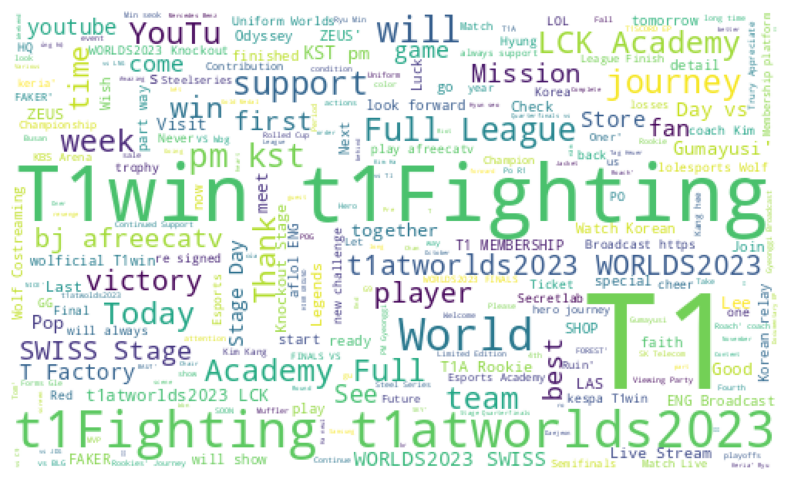

In [193]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                      max_words=300,
                      width=500, height=300
                         ).generate(text)
plt.figure(figsize=(15,6))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [194]:
# Convert to lowercase and remove punctuation
df_text['post_text_clean'] = df_text['post_text'].apply(lambda x: x.lower().translate(str.maketrans("", "", string.punctuation)))

# Tokenize each post
df_text['tokens'] = df_text['post_text_clean'].apply(lambda x: word_tokenize(x))  # Import word_tokenize from nltk.tokenize

# Remove stop words
stop_words = set(stopwords.words('english'))
df_text['filtered_tokens'] = df_text['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

# Calculate the frequency of each keyword
fdist = FreqDist(word for words in df_text['filtered_tokens'].dropna() for word in words)

# Find the most common keyword in each post
df_text['most_common_keyword'] = df_text['filtered_tokens'].apply(lambda x: fdist.max() if not x else max(set(x), key=fdist.get))

# Display the result
print(df_text[['post_text', 'most_common_keyword']])

                                             post_text most_common_keyword
125  Expand epic moments in your favorite games wit...                  t1
124  Catch every detail and conquer your fears, eve...                  t1
123  Why choose only one thing to do? See it all to...                  t1
122  [T1 x T Factory] The Hero`s Journey Pop-up sto...                  t1
121  The journey in Worlds 2023, where T1 and T1 fa...                  t1
..                                                 ...                 ...
4    [2023 #LCK Academy Full League Po R1]\n\nT1A R...          t1fighting
3    [2023 #LCK Academy Full League Finals]\n\nToda...          t1fighting
2    [2023 #LCK Academy Full League Finals]\n\nFini...          t1fighting
1    T1 League of Legends 'Roach' coach Kim Kang -h...                  t1
0    'Oner' and 'FAKER' shine in Mercedes-Benz Kore...          t1fighting

[124 rows x 2 columns]


<ipython-input-194-f7386b73ef4a>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-194-f7386b73ef4a>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-194-f7386b73ef4a>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-194-f73

In [212]:
all_tokens = [word for tokens in df_text['filtered_tokens'].dropna() for word in tokens]
fdist = FreqDist(all_tokens)
top_keywords = [word for word, freq in fdist.most_common(20)]


print("Top 10 Keywords:", top_keywords)

Top 10 Keywords: ['t1', 't1fighting', 't1win', 't1atworlds2023', '2023', 'worlds', '📺', 'pm', 'league', 'journey', 'support', 'academy', 'full', 'kst', 'worlds2023', '⏰', '’', 'day', 'stage', 'lck']


In [196]:
df['post_length'] = df['post_text'].apply(len)
print(df[['post_text', 'post_length']].head())

                                             post_text  post_length
125  Expand epic moments in your favorite games wit...          247
124  Catch every detail and conquer your fears, eve...          269
123  Why choose only one thing to do? See it all to...          208
122  [T1 x T Factory] The Hero`s Journey Pop-up sto...         2042
121  The journey in Worlds 2023, where T1 and T1 fa...          151


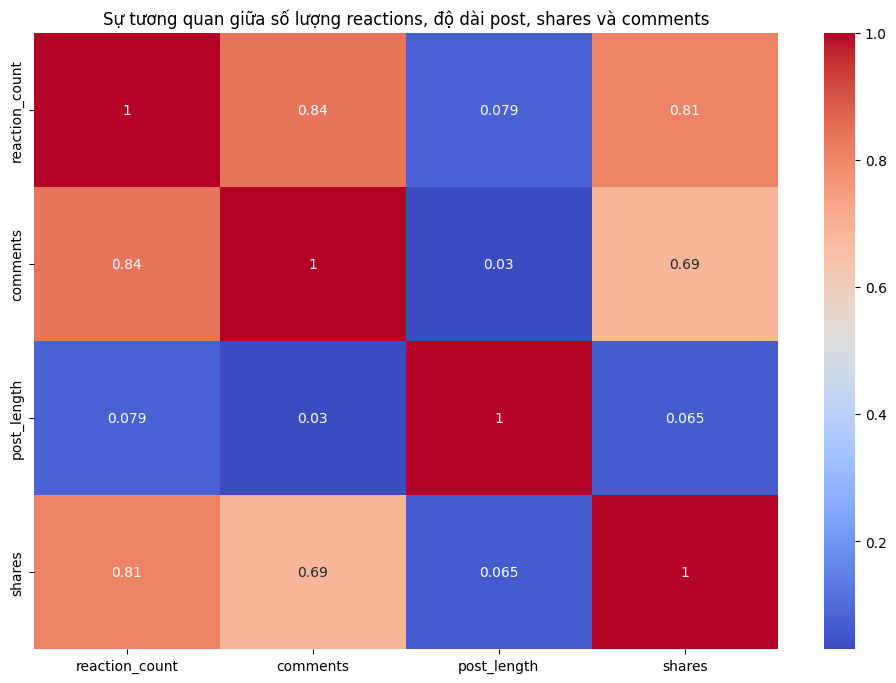

In [197]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[['reaction_count', 'comments', 'post_length', 'shares']].corr(), annot=True, cmap='coolwarm')
plt.title('Sự tương quan giữa số lượng reactions, độ dài post, shares và comments')
plt.show()

In [198]:
df['tokens'] = df['post_text'].apply(word_tokenize)

df['unique_words_count'] = df['tokens'].apply(lambda x: len(set(x)))

print(df[['post_text', 'unique_words_count']].head())

correlation = df[['unique_words_count', 'reaction_count']].corr()['reaction_count']['unique_words_count']
print(f'\nTương quan giữa số lượng từ ngữ độc đáo và lượt tương tác: {correlation}')

                                             post_text  unique_words_count
125  Expand epic moments in your favorite games wit...                  43
124  Catch every detail and conquer your fears, eve...                  44
123  Why choose only one thing to do? See it all to...                  41
122  [T1 x T Factory] The Hero`s Journey Pop-up sto...                 202
121  The journey in Worlds 2023, where T1 and T1 fa...                  21

Tương quan giữa số lượng từ ngữ độc đáo và lượt tương tác: 0.05141776690011298


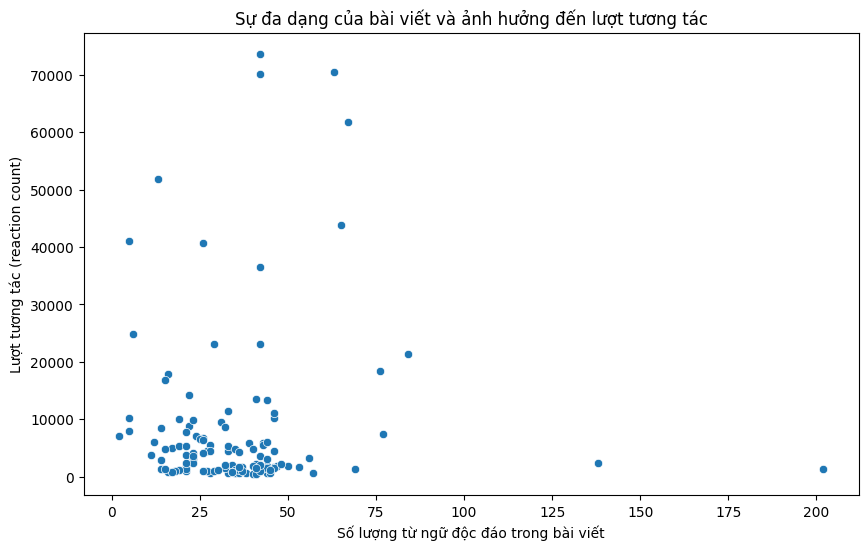

In [199]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='unique_words_count', y='reaction_count', data=df)
plt.title('Sự đa dạng của bài viết và ảnh hưởng đến lượt tương tác')
plt.xlabel('Số lượng từ ngữ độc đáo trong bài viết')
plt.ylabel('Lượt tương tác (reaction count)')
plt.show()

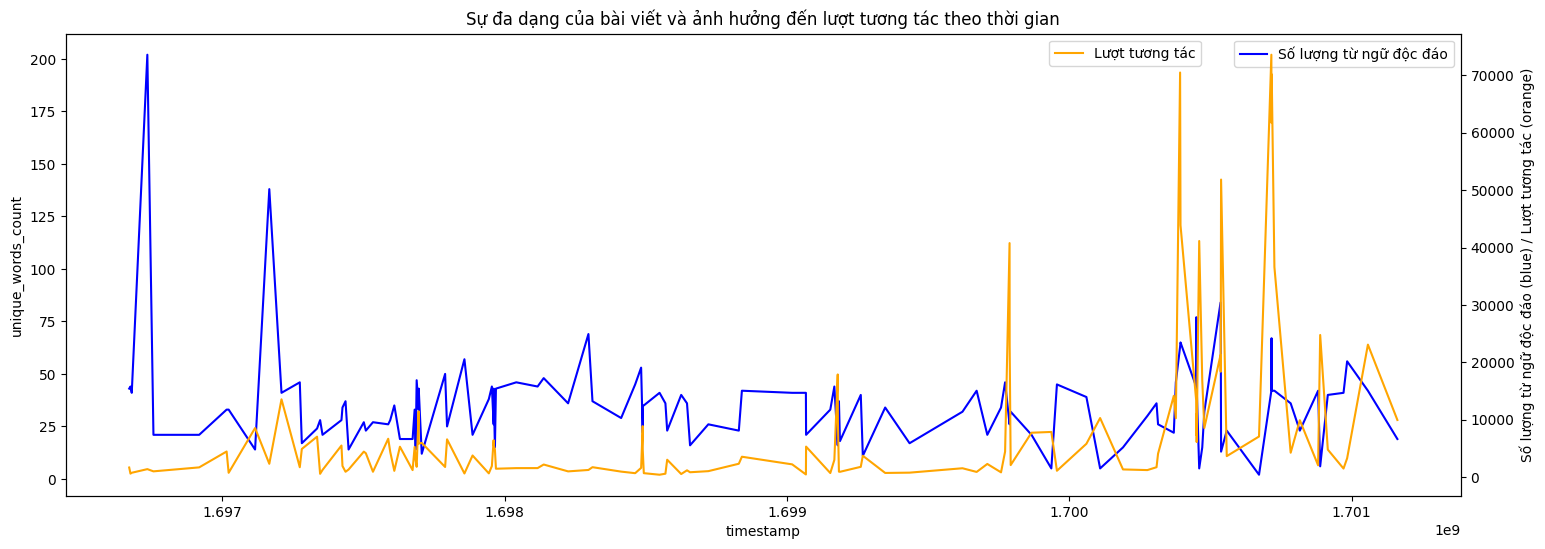

In [200]:
plt.figure(figsize=(18, 6))
sns.lineplot(x='timestamp', y='unique_words_count', data=df, label='Số lượng từ ngữ độc đáo', color='blue')

ax2 = plt.gca().twinx()
sns.lineplot(x='timestamp', y='reaction_count', data=df, label='Lượt tương tác', color='orange', ax=ax2)

plt.title('Sự đa dạng của bài viết và ảnh hưởng đến lượt tương tác theo thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Số lượng từ ngữ độc đáo (blue) / Lượt tương tác (orange)')

plt.legend(loc='upper left', bbox_to_anchor=(0.7, 1.0))

plt.show()

### **Comments Anaysis**

In [201]:
!pip install langid

In [202]:
import langid

In [203]:
path = "/content/drive/MyDrive/Colab Notebooks/Data analysis with python/T1LoL1.npy"
post_list = np.load(path,allow_pickle=True)

In [204]:
df_full_reactions

,post_id,text,post_text,time,timestamp,image,image_lowquality,images,images_description,images_lowquality,...,image_ids,fetched_time,week_of_year,thích,yêu thích,haha,wow,thương thương,buồn,phẫn nộ
125,857090949158062,Expand epic moments in your favorite games wit...,Expand epic moments in your favorite games wit...,2023-10-07 09:08:49,1696669729,NaN,https://scontent-iad3-1.xx.fbcdn.net/v/t15.525...,[],[],['https://scontent-iad3-1.xx.fbcdn.net/v/t15.5...,...,[],2023-11-28 11:45:57.442,40,713.0,562.0,382.0,11.0,12.0,1.0,NaN
124,857118535821970,"Catch every detail and conquer your fears, eve...","Catch every detail and conquer your fears, eve...",2023-10-07 10:24:07,1696674247,NaN,https://scontent-iad3-1.xx.fbcdn.net/v/t15.525...,[],[],['https://scontent-iad3-1.xx.fbcdn.net/v/t15.5...,...,[],2023-11-28 11:45:54.234,40,310.0,285.0,16.0,2.0,3.0,1.0,NaN
123,857147109152446,Why choose only one thing to do? See it all to...,Why choose only one thing to do? See it all to...,2023-10-07 11:39:01,1696678741,NaN,https://scontent-iad3-2.xx.fbcdn.net/v/t15.525...,[],[],['https://scontent-iad3-2.xx.fbcdn.net/v/t15.5...,...,[],2023-11-28 11:45:51.391,40,401.0,339.0,18.0,3.0,6.0,1.0,NaN
122,857214232479067,[T1 x T Factory] The Hero`s Journey Pop-Up Sto...,[T1 x T Factory] The Hero`s Journey Pop-up sto...,2023-10-08 03:00:02,1696734002,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,['Có thể là hình minh họa về văn bản'],['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,['857216762478814'],2023-11-28 11:45:47.470,40,785.0,594.0,2.0,4.0,15.0,NaN,NaN
121,857212265812597,T1과 T1 팬들이 함께 시작하는 Worlds 2023에서의 여정.🗺\n\nThe ...,"The journey in Worlds 2023, where T1 and T1 fa...",2023-10-08 09:00:01,1696755601,https://scontent-iad3-1.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-1.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-1.xx.fbcdn.net/v/t39.3...,"[""Có thể là hình ảnh về bản đồ và văn bản cho ...",['https://scontent-iad3-1.xx.fbcdn.net/v/t39.3...,...,[],2023-11-28 11:45:42.793,40,624.0,381.0,2.0,NaN,6.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,882554799945010,[2023 #LCK Academy Full League PO R1]\n\nT1A R...,[2023 #LCK Academy Full League Po R1]\n\nT1A R...,2023-11-25 12:32:33,1700915553,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,['Có thể là đồ họa về văn bản'],['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,['882554713278352'],2023-11-28 11:16:54.736,47,3436.0,1309.0,13.0,2.0,38.0,2.0,NaN
3,882820379918452,[2023 #LCK Academy Full League Finals]\n\n오늘은 ...,[2023 #LCK Academy Full League Finals]\n\nToda...,2023-11-26 04:00:04,1700971204,NaN,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,[],[],['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,['882820333251790'],2023-11-28 11:16:50.091,47,1146.0,342.0,4.0,1.0,8.0,NaN,NaN
2,882934579907032,[2023 #LCK Academy Full League Finals]\n\nT1A ...,[2023 #LCK Academy Full League Finals]\n\nFini...,2023-11-26 07:33:19,1700983999,https://m.facebook.com/photo/view_full_size/?f...,https://scontent-iad3-1.xx.fbcdn.net/v/t39.308...,['https://m.facebook.com/photo/view_full_size/...,['Có thể là hình ảnh về văn bản'],['https://scontent-iad3-1.xx.fbcdn.net/v/t39.3...,...,['882932703240553'],2023-11-28 11:16:37.308,47,2357.0,331.0,20.0,7.0,40.0,533.0,1.0
1,883325626534594,T1 League of Legends 'Roach' 김강희 코치가 2024년에도 T...,T1 League of Legends 'Roach' coach Kim Kang -h...,2023-11-27 04:00:05,1701057605,https://m.facebook.com/photo/view_full_size/?f...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,['https://m.facebook.com/photo/view_full_size/...,['Có thể là hình ảnh về 1 người và văn bản'],['https://scontent-iad3-2.xx.fbcdn.net/v/t39.3...,...,['883325529867937'],2023-11-28 11:16:26.347,48,13414.0,9147.0,191.0,117.0,214.0,6.0,NaN


In [205]:
import re
import datetime
def get_comments(text):
    pattern = r"\{[^{}]*\}"
    matches = re.findall(pattern, text)
    result = [eval(match) for match in matches]
    return result

In [206]:
  def creatCommentsFrame(df):
      df_result = {"comment_id" : [],
                  "commenter_id" : [],
                    "comment_text" : [],
                    "commenter_name" : [],
                    "post_id" : []}

      new_df = df[~df["comments_full"].isna()]
      for index, rows in new_df.iterrows():
          x = rows["comments_full"]
          for comment in get_comments(x):
              try:
                  print(comment)
                  df_result['comment_id'].append(comment['comment_id'])
                  df_result['commenter_id'].append(comment['commenter_id'])
                  df_result['comment_text'].append(comment['comment_text'])
                  df_result['commenter_name'].append(comment['commenter_name'])
                  df_result['post_id'].append(rows.post_id)
              except Exception as e:
                print(f"Error processing comment: {e}")
                continue
      return pd.DataFrame(df_result)
  df_cmt = creatCommentsFrame(df)
  df_cmt

{'comment_id': '284073597849075', 'comment_url': 'https://facebook.com/284073597849075', 'commenter_id': '100009727774412', 'commenter_url': 'https://facebook.com/niemstyle?eav=Afanc3aeXZh2S2DL3r3ZFZXDsgavfly5TPhns2cpyJJzKHg6F6i3aW2PSXhizgVO8ko&fref=nf&rc=p&refid=52&__tn__=%7ER&paipv=0', 'commenter_name': 'PHAN NIỆM', 'commenter_meta': None, 'comment_text': '🤣', 'comment_time': datetime.datetime(2023, 9, 28, 0, 0), 'comment_image': None, 'comment_reactors': [], 'comment_reactions': None, 'comment_reaction_count': None, 'replies': []}
{'name': 'The Anh Phùng', 'link': 'https://facebook.com/theanh.phung.56027?eav=AfZEnTU2AYf_ocYJMrJHZNDxsonulyWTeYAZdfmiT-eOxHiRcSTEnk4R9VvONip_bsY&fref=pb&paipv=0', 'type': 'haha'}
Error processing comment: 'comment_id'
{'haha': 1}
Error processing comment: 'comment_id'
{'comment_id': '3595053504085136', 'comment_url': 'https://facebook.com/3595053504085136', 'commenter_id': '100062531511978', 'commenter_url': 'https://facebook.com/theanh.phung.56027?eav=A

,comment_id,commenter_id,comment_text,commenter_name,post_id
0,284073597849075,100009727774412,🤣,PHAN NIỆM,857090949158062
1,3595053504085136,100062531511978,Nguyen Anh Khoa hảo thiệt chứ:)),The Anh Phùng,857090949158062
2,895749861886849,100012403051775,Fan cứng\nKevin Johnstone Pavilario,Kevin Johnstone Pavilario,857090949158062
3,1654019741747821,100005593051134,Thong Phan 🤣🤣🤣,Kyo Chung,857090949158062
4,1358972491367118,1270574133,Tan Chee Khai,Kai Wei Tan,857090949158062
...,...,...,...,...,...
2096,750476930250154,100001634641140,Linh Nguy,Linh Nguy,883924476474709
2097,683170593946518,100004879901188,Lại đi quay qc ở T1 hay có qc lại ngon,Ngô Minh Hải,883924476474709
2098,2294446104280478,100093690361957,🥰,Trần Nhung,883924476474709
2099,306252575614311,100015879014955,Nguyễn Đức Hiếu ngồi sang hơn được không :3,Cường Đặng,883924476474709


In [207]:
total_comments = len(df_cmt)
unique_commenters = df_cmt['commenter_id'].nunique()

print(f'Total Comments: {total_comments}')
print(f'Unique Commenters: {unique_commenters}')

df_cmt['language'] = df_cmt['comment_text'].apply(lambda x: langid.classify(x)[0])

sia = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    try:
        return sia.polarity_scores(text)['compound']
    except:
        return 0

df_cmt['sentiment_score'] = df_cmt['comment_text'].apply(get_sentiment_score)

positive_comments = len(df_cmt[df_cmt['sentiment_score'] > 0])
negative_comments = len(df_cmt[df_cmt['sentiment_score'] < 0])
neutral_comments = len(df_cmt[df_cmt['sentiment_score'] == 0])

print(f'Positive Comments: {positive_comments}')
print(f'Negative Comments: {negative_comments}')
print(f'Neutral Comments: {neutral_comments}')


Total Comments: 2101
Unique Commenters: 1539
Positive Comments: 604
Negative Comments: 142
Neutral Comments: 1355


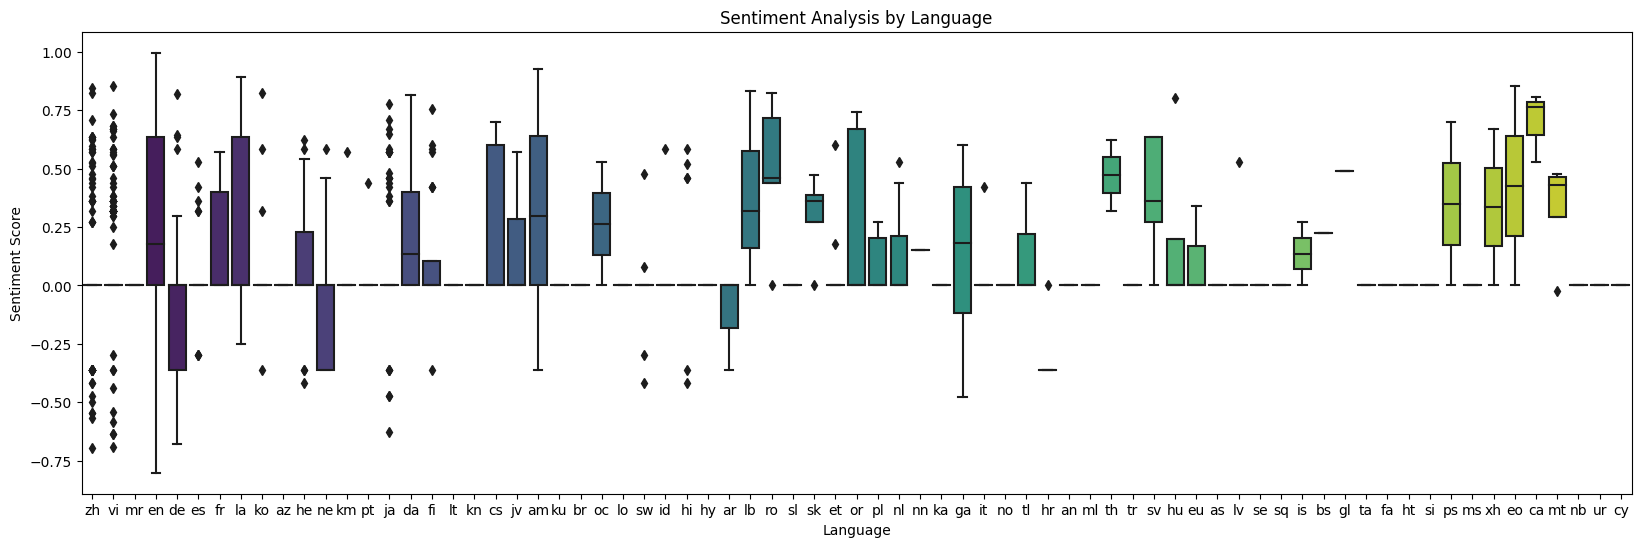

In [208]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='language', y='sentiment_score', data=df_cmt, palette='viridis')
plt.title('Sentiment Analysis by Language')
plt.xlabel('Language')
plt.ylabel('Sentiment Score')
plt.show()

In [209]:
import plotly.graph_objects as go

In [210]:
sia = SentimentIntensityAnalyzer()

def get_sentiment_category(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df_cmt['sentiment_score'] = df_cmt['comment_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
df_cmt['sentiment_category'] = df_cmt['sentiment_score'].apply(get_sentiment_category)

result_df = df_cmt.groupby(['language', 'sentiment_category']).size().reset_index(name='count')

fig = go.Figure()
fig = px.pie(result_df,
             names='sentiment_category',
             title='Sentiment Distribution by Language',
             color='sentiment_category',
             hole=0.4,
             labels={'sentiment_category': 'Sentiment'},
             color_discrete_map={'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'},
             )


fig.update_traces(textinfo='percent+label',
                  pull=[0.1, 0.1, 0.1],
                  textfont_size=14,
                  marker=dict(line=dict(color='#000000', width=2))
                  )


fig.update_layout(legend=dict(title=dict(text='Sentiment Category')))

fig.show()

In [211]:
# 4. Popular Posts
top_posts = df_cmt['post_id'].value_counts().head(5)
print('Top Posts:')
print(top_posts)

# 5. Commenter Activity
commenter_activity = df_cmt['commenter_id'].value_counts()
print('Commenter Activity:')
print(commenter_activity.head(5))

Top Posts:
880076036859553    44
881984580002032    35
864787848388372    34
882554799945010    32
862701608596996    30
Name: post_id, dtype: int64
Commenter Activity:
100009192597623    25
100008606475349    22
100027893056029    17
100025229324053    13
100005401245418    12
Name: commenter_id, dtype: int64
